尝试了 lstm，表现比 xgb 和 lgb 都要好，现在到了 0.827 分

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../src")

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from Dataset import Dataset
import tensorflow as tf
import typing
from tensorflow import keras as k

if typing.TYPE_CHECKING:
    print("emmm")
    from keras.api._v2 import keras as k

import os

os.environ["http_proxy"] = "http://localhost:6152"
os.environ["https_proxy"] = "http://localhost:6152"

In [2]:
run = neptune.init(
    project="h3z/Tabular-Playground-Series-Apr-2022",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2MDI4ZDMyYy1mODYwLTRhMzUtOWNlZC0xODBkZDIyZDkwN2QifQ==",
)  # your credentials

params = {"lr": 0.001, "epochs": 100, "batch_size": 512}
run["parameters"] = params

https://app.neptune.ai/h3z/Tabular-Playground-Series-Apr-2022/e/TAB-8
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
ds = Dataset()
sensor_cols = [f"sensor{i:02d}" for i in range(13)]

In [4]:
ds.train.query("sequence == 0").head()

,sequence,subject,step,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [5]:
def lstm_model(timesteps, feature):
    model = k.models.Sequential()
    model.add(k.layers.Input(shape=(timesteps, feature)))
    model.add(k.layers.LSTM(32))
    model.add(k.layers.Dense(1, activation="sigmoid"))
    return model

2022-04-12 22:33:34.015816: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 22:33:38.536938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38419 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-04-12 22:33:38.544010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38419 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-04-12 22:33:38.547299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 

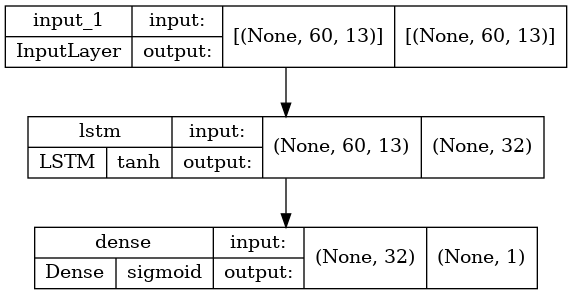

In [8]:
timesteps = ds.train.sequence.value_counts()[0]
feature = len(sensor_cols)
model = lstm_model(timesteps, feature)

X = ds.train[sensor_cols].values.reshape(-1, timesteps, 13)
y = ds.label.state.values
xy = (
    tf.data.Dataset.from_tensor_slices((X, y))
    .batch(params["batch_size"])
    .shuffle(params["batch_size"] * 4)
)

L = int(len(xy) * 0.8)

model.compile(
    optimizer=k.optimizers.Adam(),
    loss=k.losses.BinaryCrossentropy(),
    metrics=[k.metrics.BinaryAccuracy()],
)

k.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [9]:
neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

history = model.fit(
    xy.take(L),
    validation_data=xy.skip(L),
    epochs=params["epochs"],
    callbacks=[neptune_cbk],
)

Epoch 1/100


2022-04-12 22:34:13.719696: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301
2022-04-12 22:34:13.893275: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - 4s 24ms/step - loss: 0.6885 - binary_accuracy: 0.5420 - val_loss: 0.6781 - val_binary_accuracy: 0.5717
Epoch 2/100
40/40 [==============================] - 1s 15ms/step - loss: 0.6810 - binary_accuracy: 0.5655 - val_loss: 0.6803 - val_binary_accuracy: 0.5643
Epoch 3/100
40/40 [==============================] - 1s 17ms/step - loss: 0.6751 - binary_accuracy: 0.5763 - val_loss: 0.6712 - val_binary_accuracy: 0.5822
Epoch 4/100
40/40 [==============================] - 1s 15ms/step - loss: 0.6573 - binary_accuracy: 0.6053 - val_loss: 0.6418 - val_binary_accuracy: 0.6190
Epoch 5/100
40/40 [==============================] - 1s 15ms/step - loss: 0.6455 - binary_accuracy: 0.6176 - val_loss: 0.6400 - val_binary_accuracy: 0.6207
Epoch 6/100
40/40 [==============================] - 1s 14ms/step - loss: 0.6369 - binary_accuracy: 0.6264 - val_loss: 0.6266 - val_binary_accuracy: 0.6484
Epoch 7/100
40/40 [==============================] - 1s 15ms/step - loss: 0.

In [16]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [18]:
for metric in history.history.keys():
    run[f"eval/{metric}"] = history.history[metric][-1]

run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.


All 5 operations synced, thanks for waiting!


In [21]:
preds = model.predict(ds.test[sensor_cols].values.reshape(-1, timesteps, 13))
ds.submit_result(preds)